In [1]:
from tsai.all import *
import sklearn.metrics as skm
import sklearn.metrics as skm
from fastai.callback.tracker import SaveModelCallback
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
sns.set_theme(style="white")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'Arial'
my_setup()


os              : Linux-5.15.0-131-generic-x86_64-with-glibc2.35
python          : 3.10.13
tsai            : 0.3.9
fastai          : 2.7.17
fastcore        : 1.5.29
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 4090'])
cpu cores       : 16
threads per cpu : 1
RAM             : 125.64 GB
GPU memory      : [23.99] GB


## 1. prepare data

In [11]:
data_root = 'data'
label_col = 'class'

class_num = '4_class'
sp_mode = 's'

save_root = os.path.join('tsai_Models', f'{class_num}__{sp_mode}')
if not os.path.exists(save_root):
    os.makedirs(save_root)

train_val_data_path = os.path.join(f'data/{class_num}', f'train_val.csv')
test_data_path = os.path.join(f'data/{class_num}', f'test.csv')
train_val_data = pd.read_csv(train_val_data_path)
test_data = pd.read_csv(test_data_path)
train_val_data.drop(columns=[c for c in train_val_data.columns if c.startswith('p')], inplace=True)
test_data.drop(columns=[c for c in test_data.columns if c.startswith('p')], inplace=True)
print(train_val_data.shape, test_data.shape)


(36000, 33) (4000, 33)


In [12]:
random_seed = 42
train_data, val_data = train_test_split(train_val_data, test_size=5000, random_state=random_seed, stratify=train_val_data['old_class'])
train_data.drop(columns=['old_class'], inplace=True)
val_data.drop(columns=['old_class'], inplace=True)
test_data.drop(columns=['old_class'], inplace=True)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
print(train_data.shape, val_data.shape)


(31000, 32) (5000, 32)


In [13]:
X_train = train_data.drop(columns=['id', label_col]).values
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# y_train = np.array([class2idx[c] for c in train_data[label_col].values])
y_train = train_data[label_col].values

X_val = val_data.drop(columns=['id', label_col]).values
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
# y_val = np.array([class2idx[c] for c in val_data[label_col].values])
y_val = val_data[label_col].values

X_test = test_data.drop(columns=['id', label_col]).values
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# y_test = np.array([class2idx[c] for c in test_data[label_col].values])
y_test = test_data[label_col].values

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((31000, 1, 30), (31000,), (5000, 1, 30), (5000,), (4000, 1, 30), (4000,))

In [14]:
X, y, splits = combine_split_data([X_train, X_val], [y_train, y_val])
splits

((#31000) [0,1,2,3,4,5,6,7,8,9...],
 (#5000) [31000,31001,31002,31003,31004,31005,31006,31007,31008,31009...])

## 2. inspect data

In [15]:
label_counts = collections.Counter(y_val)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {'S1': 1250, 'S4': 1250, 'S2': 1250, 'S3': 1250}
Naive Accuracy: 25.00%


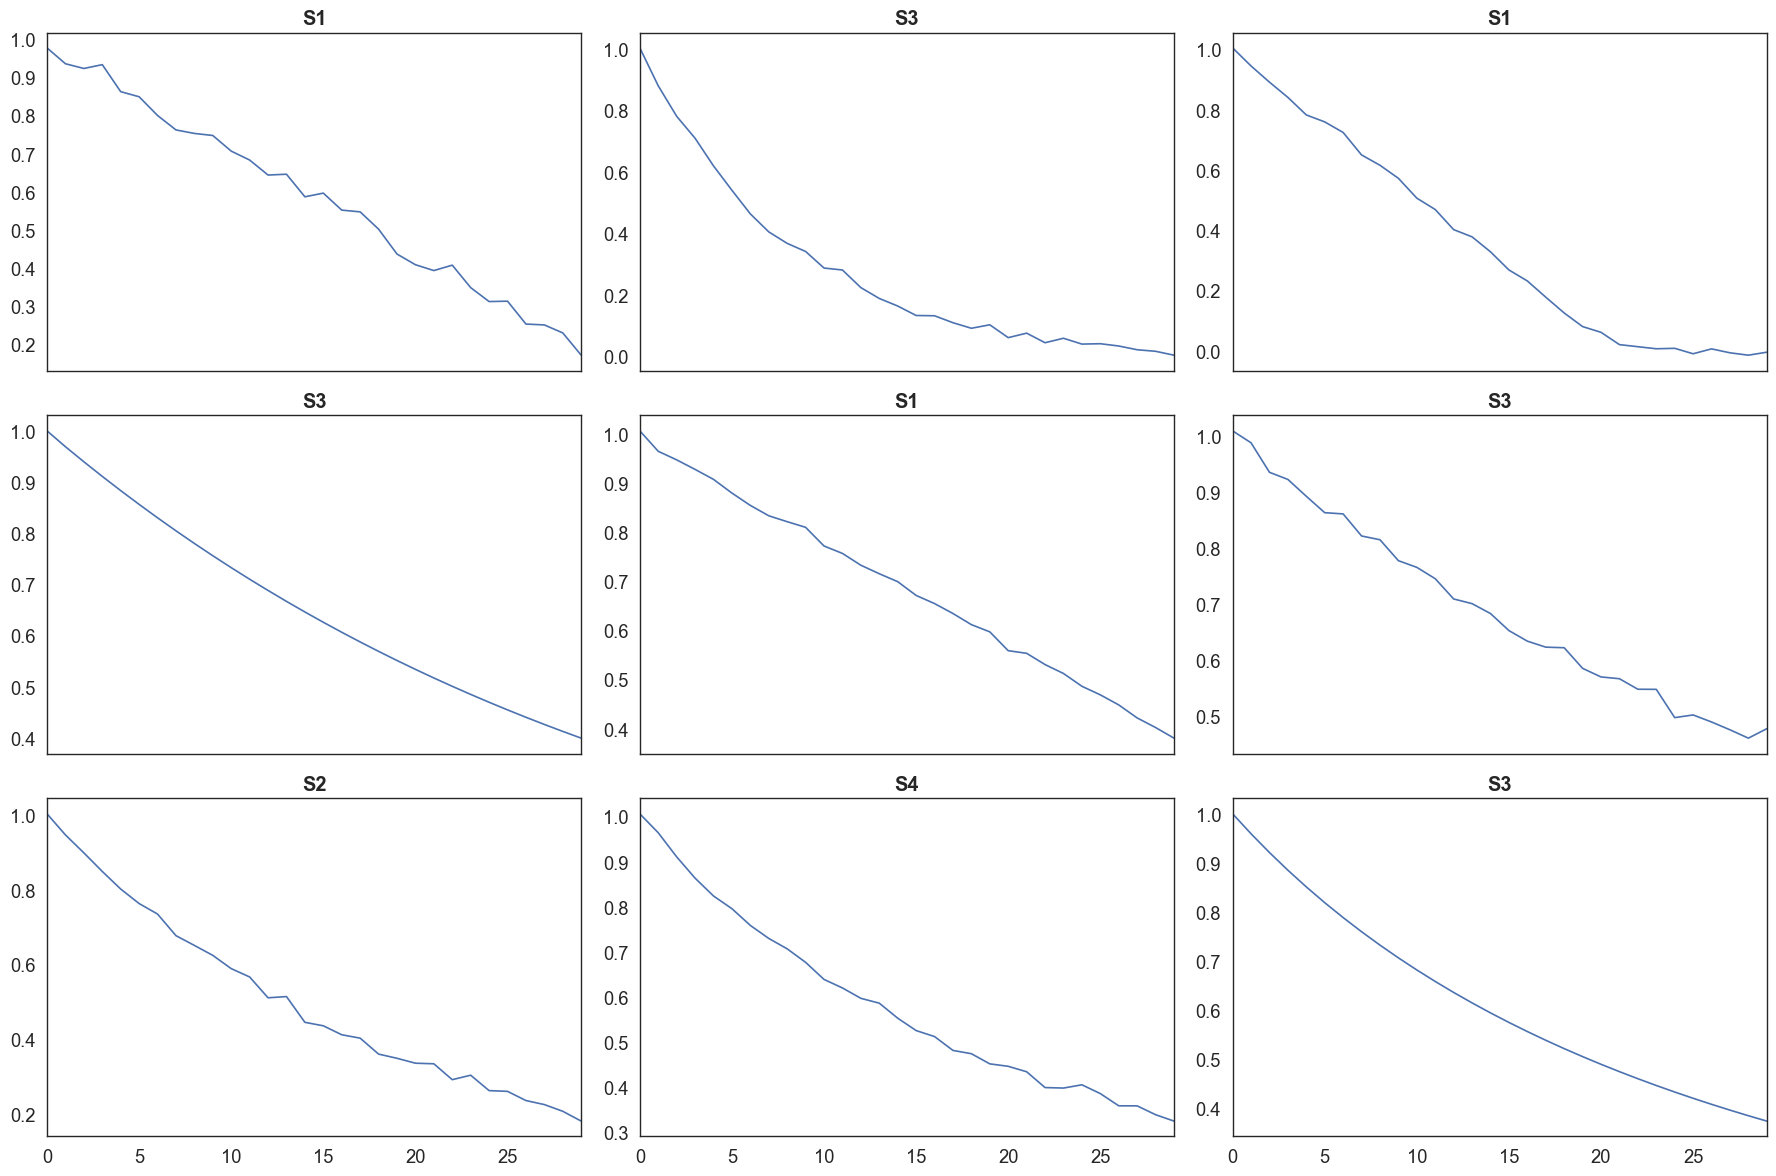

In [16]:
bs = 512

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])
test_ds = dls.dataset.add_test(X_test, y_test)
test_dl = dls.new(test_ds)
dls.show_batch()

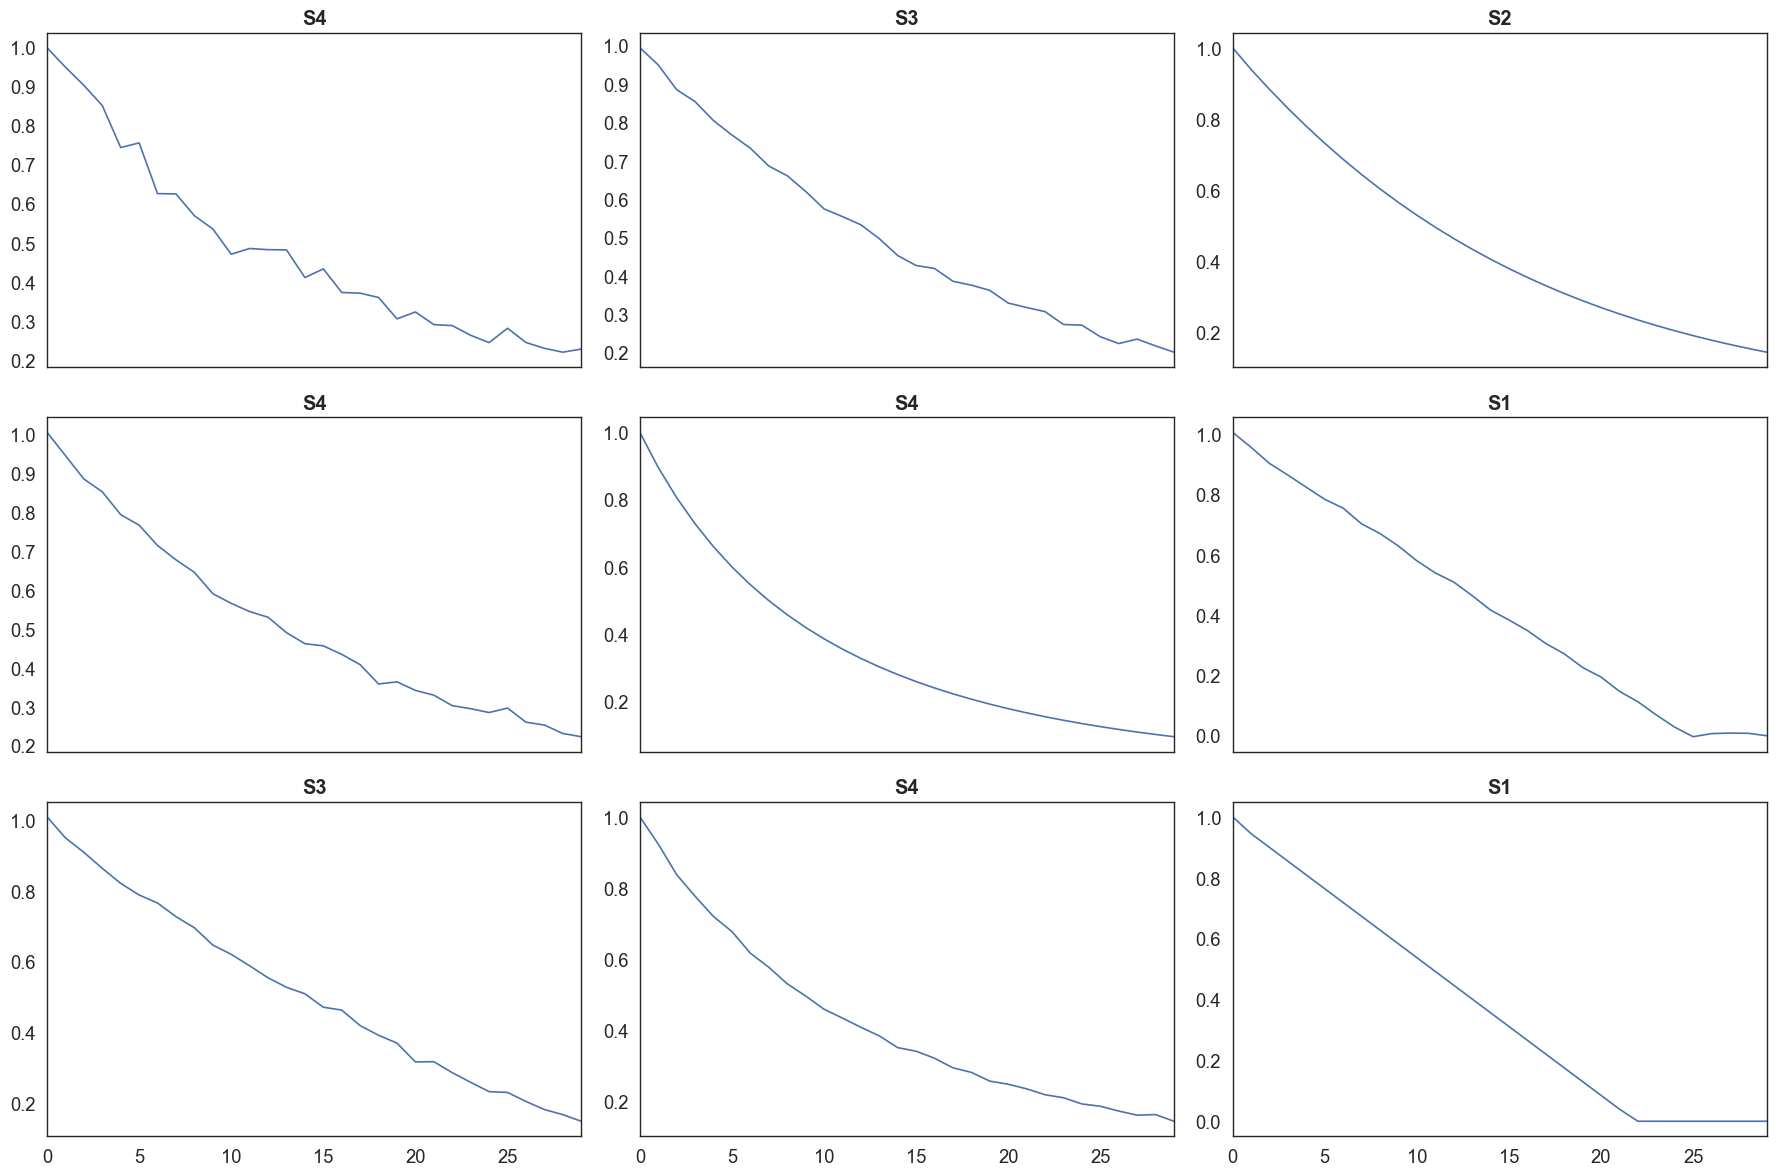

In [17]:
dls.show_batch()

## 3. Archs comparison

In [18]:
repeat_num = 3

archs = [
    # (FCN, {}), 
    (ResNet, {}), 
    # # (xresnet1d34, {}), 
    (ResCNN, {}), 
    (RNN, {'n_layers':1, 'bidirectional': False}),
    # (RNN, {'n_layers':2, 'bidirectional': False}),
    # (RNNPlus, {'n_layers':1, 'bidirectional': False}),
    # # (RNNPlus, {'n_layers':2, 'bidirectional': False}),
    # (GRU, {'n_layers':1, 'bidirectional': False}),
    # # (GRU, {'n_layers':2, 'bidirectional': False}),
    # (GRUPlus, {'n_layers':1, 'bidirectional': False}),
    # # (GRUPlus, {'n_layers':2, 'bidirectional': False}),
    (LSTM, {'n_layers':1, 'bidirectional': False}), 
    # (LSTM, {'n_layers':2, 'bidirectional': False}),
    # (LSTM, {'n_layers':3, 'bidirectional': False}),
    # (LSTMPlus, {'n_layers':1, 'bidirectional': False}),
    # (LSTMPlus, {'n_layers':2, 'bidirectional': False}),
    (LSTM, {'n_layers':1, 'bidirectional': True}), 
    # (LSTM, {'n_layers':2, 'bidirectional': True}), 
    # (LSTM, {'n_layers':3, 'bidirectional': True}),
    # (LSTMPlus, {'n_layers':1, 'bidirectional': True}),
    # (LSTMPlus, {'n_layers':2, 'bidirectional': True}),
    # (LSTM_FCN, {}), 
    # # (LSTM_FCN, {'shuffle': False}), 

    (InceptionTime, {}),
    # (InceptionTime, {

    # }),
    (InceptionTimePlus, {}),
    # (InceptionTimePlus, {

    # }),
    (XceptionTime, {}), 
    (XceptionTimePlus, {}),
    # (OmniScaleCNN, {}), 
    (mWDN, {}),
    # (mWDN, {
    #     'levels': 2,
    # }),
    # (mWDN, {
    #     'levels': 3,
    # }),
    # (mWDN, {
    #     'levels': 4,
    # }),
    (mWDNPlus, {}),
    # (mWDNPlus, {
    #     'levels': 2,
    # }),
    # (mWDNPlus, {
    #     'levels': 3,
    # }),  
    # (mWDNPlus, {
    #     'levels': 4,
    # }),
    # (mWDNPlus, {
    #     'levels': 4,
    #     'depth': 6,
    #     'ks': 40,
    #     'conv_dropout': 0.,
    #     'fc_dropout': 0.,
    #     'nf': 32,
    # }),
    # (mWDNPlus, {
    #     'levels': 3,
    #     'depth': 8,
    #     'ks': 40,
    #     'conv_dropout': 0.2,
    #     'fc_dropout': 0.0,
    #     'nf': 32,
    # }),
    (TST, {}),
    (TSTPlus, {}),

    # (TSPerceiver, {}),
    # (TSiTPlus, {}),
    # (PatchTST, {}),
    # (RNN_FCNPlus, {}),
    # (TransformerRNNPlus, {}),
    # (TransformerGRUPlus, {}),
    # (TransformerLSTMPlus, {}),

]

if os.path.exists(os.path.join(save_root, 'archs_results.csv')):
    results = pd.read_csv(os.path.join(save_root, 'archs_results.csv'))
else:
    results = pd.DataFrame(columns=[
        'arch',
        'repeat_id',
        'hyperparams', 
        'total_params', 
        'train_loss', 
        'valid_loss', 
        'val_accuracy', 
        'val_best_accuracy', 
        'test_accuracy', 
        'test_precision',
        'test_recall',
        'test_f1',
        'test_roc_auc', 
        'test_mcc',
        'time',
    ])
if os.path.exists(os.path.join(save_root, 'all_train_results.pkl')):
    with open(os.path.join(save_root, 'all_train_results.pkl'), 'rb') as f:
        all_train_results = pickle.load(f)
else:
    all_train_results = {}

if os.path.exists(os.path.join(save_root, 'all_test_results.json')):
    with open(os.path.join(save_root, 'all_test_results.json'), 'r') as f:
        all_test_results_json = json.load(f)
else:
    all_test_results_json = {}
if os.path.exists(os.path.join(save_root, 'all_test_results.pkl')):
    with open(os.path.join(save_root, 'all_test_results.pkl'), 'rb') as f:
        all_test_results = pickle.load(f)
else:
    all_test_results = {}

for i, (arch, k) in enumerate(archs):
    for repeat_id in range(repeat_num):
        model = create_model(arch, dls=dls, **k)
        name = f'{arch.__name__}__{repeat_id}'
        while name in all_test_results_json:
            name += '_'
        print(name)
        learn = Learner(dls, model, metrics=accuracy, model_dir=save_root, cbs=[ShowGraph(), SaveModelCallback(monitor='accuracy', fname=name)])
        start = time.time()

        lr_max = 0.001
        epoch = 100
        
        learn.fit_one_cycle(epoch, lr_max)
        elapsed = time.time() - start

        all_train_results[name] = learn.recorder.values

        vals = learn.recorder.values[-1]
        best_accuracy = max([item[2] for item in learn.recorder.values])
        
        model_best_epoch = learn.load(name)
        # eval on test set
        test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
        test_accuracy = skm.accuracy_score(test_targets, test_preds)
        test_precision = skm.precision_score(test_targets, test_preds, average="macro")
        test_recall = skm.recall_score(test_targets, test_preds, average="macro")
        test_f1 = skm.f1_score(test_targets, test_preds, average="macro")
        test_roc_auc = skm.roc_auc_score(test_targets, test_probas, average="macro", multi_class="ovr")
        test_mcc = skm.matthews_corrcoef(test_targets, test_preds)
        test_confusion_matrix = skm.confusion_matrix(test_targets, test_preds)
        
        all_test_results_json[name] = {
            # 'test_probas': test_probas.tolist(),
            # 'test_targets': test_targets.tolist(),
            # 'test_preds': test_preds.tolist(),
            'hyper_params': k,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'test_roc_auc': test_roc_auc,
            'test_mcc': test_mcc,
            # 'test_confusion_matrix': test_confusion_matrix.tolist(),
        }
        all_test_results[name] = {
            'hyper_params': k,
            'test_probas': test_probas,
            'test_targets': test_targets,
            'test_preds': test_preds,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'test_roc_auc': test_roc_auc,
            'test_mcc': test_mcc,
            'test_confusion_matrix': test_confusion_matrix,
        }
        results.loc[len(results)] = [arch.__name__, repeat_id, k, count_parameters(model), vals[0], vals[1], vals[2], best_accuracy, test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_mcc, int(elapsed)]
        results.sort_values(by='test_accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
        clear_output()
        display(results)
        with open(os.path.join(save_root, 'all_train_results.pkl'), 'wb') as f:
            pickle.dump(all_train_results, f)
        with open(os.path.join(save_root, 'all_test_results.json'), 'w') as f:
            json.dump(all_test_results_json, f, indent=2)
        with open(os.path.join(save_root, 'all_test_results.pkl'), 'wb') as f:
            pickle.dump(all_test_results, f)
        results.to_csv(os.path.join(save_root, 'archs_results.csv'), index=False)

,arch,repeat_id,hyperparams,total_params,train_loss,valid_loss,val_accuracy,val_best_accuracy,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_mcc,time
0,InceptionTimePlus,0,{},455364,0.405924,0.455477,0.7998,0.8018,0.79875,0.799465,0.79875,0.794084,0.955605,0.734758,73
1,InceptionTime,2,{},388868,0.381988,0.466880,0.7980,0.8010,0.79850,0.798438,0.79850,0.793733,0.953534,0.734245,71
2,InceptionTimePlus,1,{},455364,0.400627,0.457318,0.8056,0.8056,0.79675,0.797430,0.79675,0.792015,0.954333,0.732132,72
3,InceptionTimePlus,2,{},455364,0.387560,0.468479,0.7948,0.7968,0.79400,0.794644,0.79400,0.788637,0.953420,0.728829,72
4,InceptionTime,0,{},388868,0.377217,0.468579,0.8036,0.8052,0.79275,0.793039,0.79275,0.788266,0.952096,0.726527,70
5,InceptionTime,1,{},388868,0.377602,0.465757,0.7992,0.8010,0.79200,0.792461,0.79200,0.787430,0.952089,0.725578,71
6,XceptionTime,1,{},399480,0.470394,0.487599,0.7984,0.7984,0.78800,0.787463,0.78800,0.783210,0.951137,0.720096,76
7,XceptionTimePlus,0,{},399480,0.466667,0.488918,0.7932,0.7938,0.78800,0.787119,0.78800,0.783610,0.949918,0.719726,76
8,XceptionTimePlus,2,{},399480,0.472034,0.491709,0.7924,0.7938,0.78625,0.785460,0.78625,0.781774,0.949404,0.717491,76
9,XceptionTimePlus,1,{},399480,0.466743,0.486880,0.7940,0.7956,0.78600,0.786146,0.78600,0.780443,0.950139,0.718117,76


## 5. Figure S4: benchmark results

In [2]:
data_root = 'data'
label_col = 'class'

class_num = '4_class'
sp_mode = 's'

save_root = os.path.join('tsai_Models', f'{class_num}__{sp_mode}')
results = pd.read_csv(os.path.join(save_root, 'archs_results.csv'))

results = pd.concat([results, pd.DataFrame({
    "arch": ["COSORK (AutoGluon)"],
    "test_accuracy": [0.8077],
    "test_mcc": [0.7472],
    "test_precision": [0.8092],
    "test_recall": [0.8077],
    "test_f1": [0.8028],
    "test_roc_auc": [0.9587],
})], ignore_index=True)

results = results.sort_values(by='test_accuracy', ascending=False)
results

,arch,repeat_id,hyperparams,total_params,train_loss,valid_loss,val_accuracy,val_best_accuracy,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_mcc,time
39,COSORK (AutoGluon),NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.80770,0.809200,0.80770,0.802800,0.958700,0.747200,NaN
0,InceptionTimePlus,0.0,{},455364.0,0.405924,0.455477,0.7998,0.8018,0.79875,0.799465,0.79875,0.794084,0.955605,0.734758,73.0
1,InceptionTime,2.0,{},388868.0,0.381988,0.466880,0.7980,0.8010,0.79850,0.798438,0.79850,0.793733,0.953534,0.734245,71.0
2,InceptionTimePlus,1.0,{},455364.0,0.400627,0.457318,0.8056,0.8056,0.79675,0.797430,0.79675,0.792015,0.954333,0.732132,72.0
3,InceptionTimePlus,2.0,{},455364.0,0.387560,0.468479,0.7948,0.7968,0.79400,0.794644,0.79400,0.788637,0.953420,0.728829,72.0
4,InceptionTime,0.0,{},388868.0,0.377217,0.468579,0.8036,0.8052,0.79275,0.793039,0.79275,0.788266,0.952096,0.726527,70.0
5,InceptionTime,1.0,{},388868.0,0.377602,0.465757,0.7992,0.8010,0.79200,0.792461,0.79200,0.787430,0.952089,0.725578,71.0
6,XceptionTime,1.0,{},399480.0,0.470394,0.487599,0.7984,0.7984,0.78800,0.787463,0.78800,0.783210,0.951137,0.720096,76.0
7,XceptionTimePlus,0.0,{},399480.0,0.466667,0.488918,0.7932,0.7938,0.78800,0.787119,0.78800,0.783610,0.949918,0.719726,76.0
8,XceptionTimePlus,2.0,{},399480.0,0.472034,0.491709,0.7924,0.7938,0.78625,0.785460,0.78625,0.781774,0.949404,0.717491,76.0


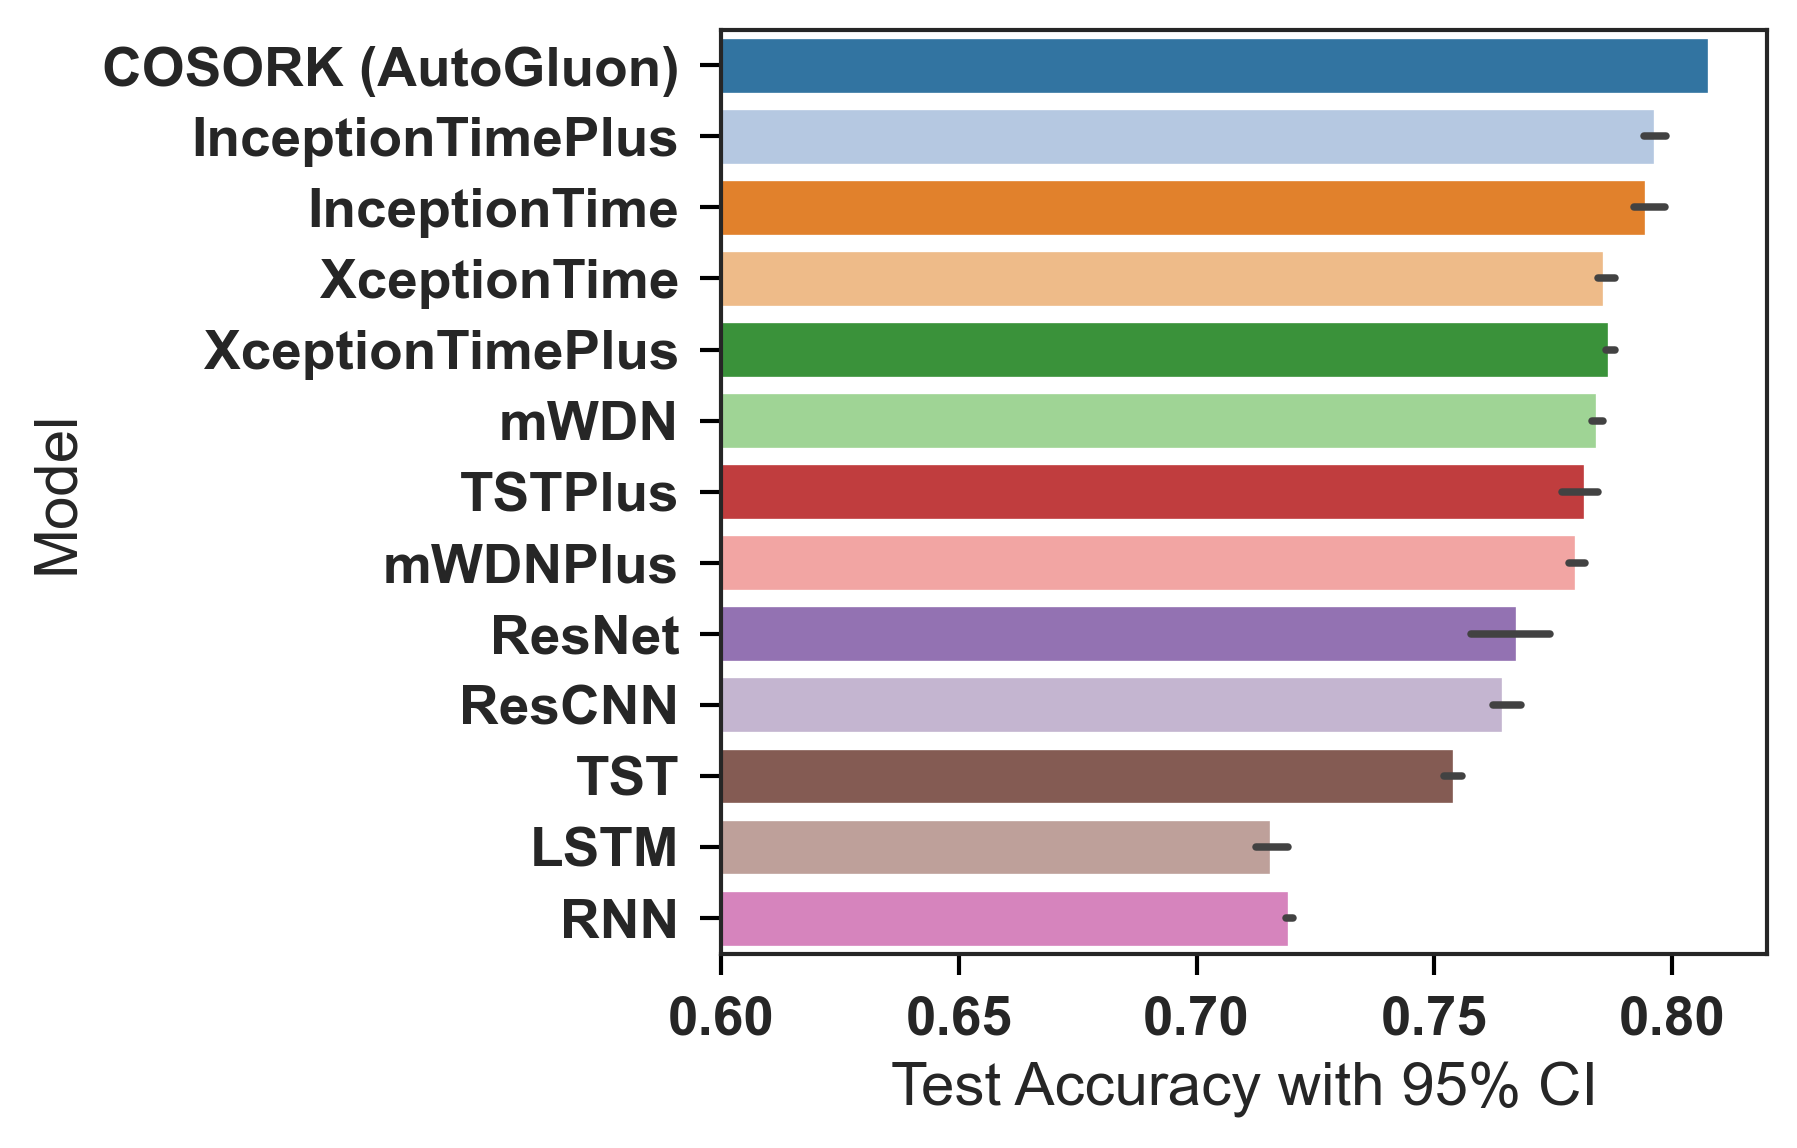

In [3]:
plt.figure(figsize=(4.5, 4), dpi=300)
sns.barplot(x='test_accuracy', y='arch', data=results, errorbar='ci', ci=95, palette='tab20')
plt.xlim(0.6, 0.82)
plt.ylabel('Model')
plt.xlabel('Test Accuracy with 95% CI')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1)
ax.tick_params(
    axis='both',
    which='major',
    direction='out',
    length=5,
    width=1,
    color='black',
    pad=5,
    bottom=True,  # Ensure ticks are drawn on the required edges
    left=True,    # Ensure ticks are drawn on the required edges
    top=False,    # Typically, ticks are not shown on the top and right
    right=False   # Color of the ticks (can be adjusted as needed)
)
ax.tick_params(
    axis='x', # Apply only to the X-axis
    which='minor',
    direction='out',
    length=2.5, # Minor ticks are usually shorter than major ticks
    width=0.7,  # Minor ticks are usually thinner than major ticks
    color='black', # Consistent or slightly lighter than major ticks
    bottom=True,
    top=False
)